## Correlation-Attack

In [3]:
#import python libraries
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tnrange,tqdm_notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
from tqdm import tnrange,tqdm_notebook

### Read Data 

In [4]:
simulated_traces = pd.read_csv('../real_traces/SBOX_traces2019-11-10_19_51_35/traces/trace_sliced_0_1.csv',low_memory=False)
simulated_metadata= pd.read_csv('../real_traces/SBOX_traces2019-11-10_19_51_35/label/label_0_1.csv')
simulated_traces = np.array(simulated_traces)
simulated_metadata = np.array(simulated_metadata)

In [5]:
len(simulated_traces.transpose())

10000

## Correltion Example

In [6]:
mergedData = np.column_stack((pd.DataFrame(simulated_metadata).transpose(), simulated_metadata.T))
df_merged_mergedData = pd.DataFrame(mergedData)

In [7]:
# Draw correlation with SAS
def drawCorr(df):
    sns.set(style="white")
    sns.set_palette("coolwarm",9)
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmax=1, center=0, vmin=-1,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns.set_style("whitegrid")

In [ ]:
from numpy import *

tmpCorr = []
test = pd.DataFrame(simulated_metadata).transpose()
for i in range(0,5000):
    mergedData = np.column_stack((np.array(test)[i], simulated_metadata))   
    df_merged_mergedData = pd.DataFrame(mergedData)
    #print(i,df_merged_mergedData.corr().unstack().sort_values().drop_duplicates()[0:1].values)
    tmpCorr.append(df_merged_mergedData.corr().unstack().sort_values().drop_duplicates()[0:1].values[0]) 
    
corr_index = np.argmax(tmpCorr)
print(corr_index) 

## Attack 1 - Correlation

In [9]:
# AES Sbox
AES_Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])

In [10]:
# Compute the HW for the key and plaintext
def computeHW(plaintext,key):
    listHW = []
    for p in plaintext:
        tmpHW = AES_Sbox[int(p)^key] 
        listHW.append(tmpHW)
    return np.array(listHW)

In [11]:
# Get the key by the maximum correlation
def getKey(keyList):
    tmpCorr = []
    for i in keyList:
        tmpCorr.append(i[1])
    keyIndex = np.argmax(tmpCorr)
    return(keyList[keyIndex])

In [12]:
import time

def startCorrelationAttack(traces,metadata):
    #tmpCorr = []
    tmpList=[]
    fullList = []
    print('--- Start Correlation Attack ---')
    for i in tnrange(0,10000):
        tmpCorr = []
        keylist = []
        #print('Sample:',i)
        for k in range(23,24):
            # Compute the HW of the current key
            tmpHW = computeHW(metadata.T,k)
            # Create new arrawy with the races 
            mergedData = np.column_stack((traces.T[i], tmpHW.T))
            # Tranform array to DataFrame
            df_mergedData = pd.DataFrame(mergedData)
            #print(mergedData)
            # Get correlation 
            tmpCorr.append(df_mergedData.corr().unstack().sort_values().drop_duplicates()[0:1].values[0])
            # Add current key to list
            keylist.append(k)
        # Get maximum correlation per sample
        fullList.append((np.argmax(tmpCorr),tmpCorr))
        tmpList.append((keylist[np.argmax(tmpCorr)],np.max(tmpCorr),i))
    # Get the final key
    print('--- Finished Correlation Attack ---',i,time.time())
    finalKey = getKey(tmpList)
    print('Key:',finalKey[0],'\nSample:',finalKey[2],'\nCorrelation:',finalKey[1]) 
    
    #finalData = [fullList,tmpList]
    finalData = [finalKey[0],finalKey[2],finalKey[1]]
    return finalData
    #%matplotlib inline
    #import mpld3
    #mpld3.enable_notebook()

In [13]:
import time

def startCorrelationAttackSingle(traces,metadata):
    #tmpCorr = []
    tmpList=[]
    fullList = []
    print('--- Start Correlation Attack ---')
    for i in tnrange(0,10000):
        tmpCorr = []
        keylist = []
        #print('Sample:',i)
        for k in range(0,255):
            # Compute the HW of the current key
            tmpHW = computeHW(metadata.T,k)
            # Create new arrawy with the races 
            mergedData = np.column_stack((traces.T[i], tmpHW.T))
            # Tranform array to DataFrame
            df_mergedData = pd.DataFrame(mergedData)
            #print(mergedData)
            # Get correlation 
            tmpCorr.append(df_mergedData.corr().unstack().sort_values().drop_duplicates()[0:1].values[0])
            # Add current key to list
            keylist.append(k)
        # Get maximum correlation per sample
        fullList.append((np.argmax(tmpCorr),tmpCorr))
        tmpList.append((keylist[np.argmax(tmpCorr)],np.max(tmpCorr),i))
    # Get the final key
    print('--- Finished Correlation Attack ---',i,time.time())
    finalKey = getKey(tmpList)
    print('Key:',finalKey[0],'\nSample:',finalKey[2],'\nCorrelation:',finalKey[1]) 
    
    finalData = [fullList,tmpList]
    #finalData = [finalKey[0],finalKey[2],finalKey[1]]
    return finalData
    #%matplotlib inline
    #import mpld3
    #mpld3.enable_notebook()

In [8]:
pd.DataFrame(simulated_traces[0:1000].T[0])

,0
0,126.111111
1,110.777778
2,116.777778
3,126.111111
4,120.444444
...,...
495,105.222222
496,118.888889
497,112.888889
498,115.888889


In [9]:
pd.DataFrame(simulated_metadata.T[0:1000])

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,254.0,66.0,249.0,126.0,20.0,110.0,119.0,159.0,129.0,249.0,...,240.0,189.0,197.0,58.0,162.0,66.0,14.0,115.0,89.0,206.0


In [14]:
allAttracks = []
for i in tnrange(0,20):
    for j in range(0,20):
        simulated_traces = pd.read_csv('../real_traces/ /traces/trace_sliced_'+ str(i)+'_'+ str(j) +'.csv',low_memory=False)
        simulated_metadata= pd.read_csv('../real_traces/SBOX_traces2019-11-10_19_51_35/label/label_'+ str(i)+'_'+ str(j) +'.csv',low_memory=False)
        simulated_traces = np.array(simulated_traces)
        simulated_metadata = np.array(simulated_metadata)
        
        corrAttackData = startCorrelationAttack(simulated_traces[0:1000],simulated_metadata.T[0:1000])
        allAttracks.append(corrAttackData)

--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573527988.6905928
Key: 23 
Sample: 6993 
Correlation: 0.17816255392087627
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528009.916032
Key: 23 
Sample: 7242 
Correlation: 0.1766364603223295
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528031.4922922
Key: 23 
Sample: 6993 
Correlation: 0.23423398149509556
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528053.006825
Key: 23 
Sample: 7242 
Correlation: 0.24904586219235128
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528074.498398
Key: 23 
Sample: 6533 
Correlation: 0.14641644995178046
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528095.9459329
Key: 23 
Sample: 4722 
Correlation: 0.15204846475511474
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528117.7165232
Key: 23 
Sample: 7240 
Correlation: 0.1926858677411715
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528139.1896088
Key: 23 
Sample: 7240 
Correlation: 0.28148600015778424
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528160.8021955
Key: 23 
Sample: 7240 
Correlation: 0.2975864277901815
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528182.328117
Key: 23 
Sample: 7240 
Correlation: 0.22665446417604168
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528203.9727726
Key: 23 
Sample: 8811 
Correlation: 0.1931335089927112
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528225.4472044
Key: 23 
Sample: 6991 
Correlation: 0.164779700908787
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528246.88277
Key: 23 
Sample: 7239 
Correlation: 0.18871063782264236
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528268.3700948
Key: 23 
Sample: 7240 
Correlation: 0.22804391653638967
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528289.8469667
Key: 23 
Sample: 7239 
Correlation: 0.21340303821359052
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528311.307235
Key: 23 
Sample: 7240 
Correlation: 0.22240834448509111
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528332.9555147
Key: 23 
Sample: 6996 
Correlation: 0.16532923949756176
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528354.322438
Key: 23 
Sample: 2328 
Correlation: 0.18807021717744768
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528375.7723854
Key: 23 
Sample: 4182 
Correlation: 0.1584224930278616
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528397.2867887
Key: 23 
Sample: 3371 
Correlation: 0.1322075534184988
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528418.910257
Key: 23 
Sample: 3156 
Correlation: 0.16394015510431992
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528440.5268903
Key: 23 
Sample: 7242 
Correlation: 0.2349032298729911
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528461.8780725
Key: 23 
Sample: 7242 
Correlation: 0.252403862368757
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528483.3802025
Key: 23 
Sample: 7242 
Correlation: 0.2134718779018678
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528504.8761423
Key: 23 
Sample: 7242 
Correlation: 0.2575427254253714
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528526.35296
Key: 23 
Sample: 7242 
Correlation: 0.24544694031587586
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528548.0739655
Key: 23 
Sample: 2020 
Correlation: 0.13248859675894561
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528569.5437052
Key: 23 
Sample: 5851 
Correlation: 0.1582981258930359
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528591.246273
Key: 23 
Sample: 7240 
Correlation: 0.3498939098479927
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528612.8231757
Key: 23 
Sample: 7240 
Correlation: 0.2599071944298138
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528634.4392176
Key: 23 
Sample: 6990 
Correlation: 0.2275896055216038
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528655.851695
Key: 23 
Sample: 7240 
Correlation: 0.22563307529050916
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528677.4468005
Key: 23 
Sample: 7240 
Correlation: 0.21443456592082208
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528698.9346144
Key: 23 
Sample: 7240 
Correlation: 0.2514328325448985
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528720.3969166
Key: 23 
Sample: 6991 
Correlation: 0.16591803913050163
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528741.998616
Key: 23 
Sample: 7240 
Correlation: 0.1821853324968921
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528763.4176867
Key: 23 
Sample: 7239 
Correlation: 0.18033527234660246
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528784.9915204
Key: 23 
Sample: 3876 
Correlation: 0.16280088461163483
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528806.726088
Key: 23 
Sample: 8785 
Correlation: 0.1732454133715282
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528828.298924
Key: 23 
Sample: 6183 
Correlation: 0.1471048646269014
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528849.9951158
Key: 23 
Sample: 7580 
Correlation: 0.1485887476568738
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528871.6777363
Key: 23 
Sample: 920 
Correlation: 0.1649931445781454
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528893.3651145
Key: 23 
Sample: 1787 
Correlation: 0.19497494285741102
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528914.8043957
Key: 23 
Sample: 7242 
Correlation: 0.2172589183717129
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528936.4829552
Key: 23 
Sample: 6993 
Correlation: 0.1932370115061558
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528958.0946355
Key: 23 
Sample: 6993 
Correlation: 0.25243666292750777
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573528979.651834
Key: 23 
Sample: 7242 
Correlation: 0.2599131911042208
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529001.3345053
Key: 23 
Sample: 2186 
Correlation: 0.1638707979420347
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529022.7238748
Key: 23 
Sample: 749 
Correlation: 0.1603278766431997
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529044.4037526
Key: 23 
Sample: 7240 
Correlation: 0.3086502374265287
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529065.8999214
Key: 23 
Sample: 7240 
Correlation: 0.28731104263762963
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529087.617611
Key: 23 
Sample: 7240 
Correlation: 0.27077274797921974
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529109.1448772
Key: 23 
Sample: 7240 
Correlation: 0.24993627759678075
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529130.6987326
Key: 23 
Sample: 7240 
Correlation: 0.2729698493778408
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529152.1877341
Key: 23 
Sample: 7240 
Correlation: 0.24808964247405388
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529173.7601159
Key: 23 
Sample: 7239 
Correlation: 0.22461390940507478
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529195.123776
Key: 23 
Sample: 6992 
Correlation: 0.2020629557081063
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529216.958795
Key: 23 
Sample: 7239 
Correlation: 0.12654055375261536
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529238.5667403
Key: 23 
Sample: 7239 
Correlation: 0.18543261302450745
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529260.398358
Key: 23 
Sample: 6908 
Correlation: 0.14410162380372019
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529281.9702566
Key: 23 
Sample: 6436 
Correlation: 0.1663718731333603
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529303.8034253
Key: 23 
Sample: 4620 
Correlation: 0.15890411622172299
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529325.2835262
Key: 23 
Sample: 5786 
Correlation: 0.16116493262504458
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529346.7825809
Key: 23 
Sample: 957 
Correlation: 0.14866283309457037
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529368.60867
Key: 23 
Sample: 7242 
Correlation: 0.20427284952797256
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529390.0449784
Key: 23 
Sample: 6993 
Correlation: 0.17415246429656717
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529411.767792
Key: 23 
Sample: 7242 
Correlation: 0.20113246052183367
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529433.631284
Key: 23 
Sample: 7242 
Correlation: 0.2349170469929498
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529455.3151724
Key: 23 
Sample: 6993 
Correlation: 0.17600693931355393
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529477.0964265
Key: 23 
Sample: 7728 
Correlation: 0.1835143832155598
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529498.6736245
Key: 23 
Sample: 7240 
Correlation: 0.25359742483582987
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529520.4740546
Key: 23 
Sample: 7240 
Correlation: 0.2936500774238364
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529542.2590568
Key: 23 
Sample: 7240 
Correlation: 0.3874434958528762
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529564.0201719
Key: 23 
Sample: 7240 
Correlation: 0.21684064876705794
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529585.4365451
Key: 23 
Sample: 7240 
Correlation: 0.23485883808665578
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529607.057202
Key: 23 
Sample: 6991 
Correlation: 0.19213563292531646
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529629.2858083
Key: 23 
Sample: 6990 
Correlation: 0.161710166900174
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529650.8921
Key: 23 
Sample: 7239 
Correlation: 0.2205791846016078
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529672.7166345
Key: 23 
Sample: 7239 
Correlation: 0.25299057265336045
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529693.9816415
Key: 23 
Sample: 7995 
Correlation: 0.16083702462224264
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529715.6421814
Key: 23 
Sample: 8662 
Correlation: 0.16990705126454705
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529737.201783
Key: 23 
Sample: 7256 
Correlation: 0.17053773470530814
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529758.6737802
Key: 23 
Sample: 2140 
Correlation: 0.17070395990434567
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529779.9388201
Key: 23 
Sample: 6605 
Correlation: 0.14868757718244166
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529801.268598
Key: 23 
Sample: 1524 
Correlation: 0.18997464432375455
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529822.731633
Key: 23 
Sample: 6993 
Correlation: 0.1352189567313127
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529843.9905016
Key: 23 
Sample: 6993 
Correlation: 0.13715512098266044
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529865.3791125
Key: 23 
Sample: 7242 
Correlation: 0.1815422661420227
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529887.0116308
Key: 23 
Sample: 6993 
Correlation: 0.19377645138825922
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529908.9791987
Key: 23 
Sample: 6993 
Correlation: 0.21013351852171205
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529930.8200908
Key: 23 
Sample: 6974 
Correlation: 0.10600909796129515
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529952.042481
Key: 23 
Sample: 6990 
Correlation: 0.15766053509878974
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529973.462756
Key: 23 
Sample: 7240 
Correlation: 0.25183000891024515
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573529994.2385244
Key: 23 
Sample: 6991 
Correlation: 0.22882740839943538
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530015.6427078
Key: 23 
Sample: 6992 
Correlation: 0.22679783821706034
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530036.6522262
Key: 23 
Sample: 6991 
Correlation: 0.22461694275384836
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530058.0406759
Key: 23 
Sample: 7240 
Correlation: 0.27337123236403826
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530079.255109
Key: 23 
Sample: 6991 
Correlation: 0.1980369361575037
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530100.7981575
Key: 23 
Sample: 7239 
Correlation: 0.1359846643763297
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530122.2337265
Key: 23 
Sample: 6447 
Correlation: 0.1794454292336402
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530143.529676
Key: 23 
Sample: 7239 
Correlation: 0.15566940903423865
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530164.943206
Key: 23 
Sample: 9024 
Correlation: 0.13934735168738585
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530186.1347008
Key: 23 
Sample: 6474 
Correlation: 0.12335475477971948
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530207.4660134
Key: 23 
Sample: 851 
Correlation: 0.1482305063082217
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530228.6169422
Key: 23 
Sample: 7673 
Correlation: 0.1419138082128456
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530249.8359742
Key: 23 
Sample: 2437 
Correlation: 0.1304032727901194
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530271.2236443
Key: 23 
Sample: 6992 
Correlation: 0.1189759591008483
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530292.4687474
Key: 23 
Sample: 7242 
Correlation: 0.1297763067736142
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530313.8777056
Key: 23 
Sample: 1848 
Correlation: 0.1315706819528734
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530335.0231566
Key: 23 
Sample: 7242 
Correlation: 0.1917175002575344
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530356.2942445
Key: 23 
Sample: 7242 
Correlation: 0.1806385006377706
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530377.5332484
Key: 23 
Sample: 7242 
Correlation: 0.16540908551813893
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530399.187308
Key: 23 
Sample: 8660 
Correlation: 0.15105788070576676
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530420.5214224
Key: 23 
Sample: 7240 
Correlation: 0.24273241178300559
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530441.7912216
Key: 23 
Sample: 7240 
Correlation: 0.22462199289203486
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530463.335706
Key: 23 
Sample: 7240 
Correlation: 0.2759790932173553
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530484.4809854
Key: 23 
Sample: 6991 
Correlation: 0.15166902245947947
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530506.7080693
Key: 23 
Sample: 7240 
Correlation: 0.2809885519984079
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530528.658838
Key: 23 
Sample: 7240 
Correlation: 0.19096518662342926
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530549.9498348
Key: 23 
Sample: 6182 
Correlation: 0.12545280496768024
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530571.5883675
Key: 23 
Sample: 147 
Correlation: 0.14017654791350728
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530593.1547863
Key: 23 
Sample: 1675 
Correlation: 0.14301232859201257
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530614.964935
Key: 23 
Sample: 856 
Correlation: 0.15130279441033453
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530636.52743
Key: 23 
Sample: 8252 
Correlation: 0.14967597444485137
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530658.3660698
Key: 23 
Sample: 9014 
Correlation: 0.19114249630176944
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530679.9023733
Key: 23 
Sample: 5849 
Correlation: 0.16529056479089044
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530701.5394378
Key: 23 
Sample: 6995 
Correlation: 0.13066821082744637
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530723.36893
Key: 23 
Sample: 1131 
Correlation: 0.12811827763705483
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530745.0331016
Key: 23 
Sample: 6993 
Correlation: 0.1437074197676713
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530767.0816834
Key: 23 
Sample: 6993 
Correlation: 0.11881219147900754
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530789.0829325
Key: 23 
Sample: 7242 
Correlation: 0.12700968847328764
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530810.8673682
Key: 23 
Sample: 6993 
Correlation: 0.14083935494198235
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530832.36456
Key: 23 
Sample: 7242 
Correlation: 0.19857732010731405
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530854.075436
Key: 23 
Sample: 1869 
Correlation: 0.11340075656137598
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530875.5458722
Key: 23 
Sample: 7239 
Correlation: 0.17875657693544075
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530896.7613757
Key: 23 
Sample: 6992 
Correlation: 0.26726772112327446
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530918.0576925
Key: 23 
Sample: 7240 
Correlation: 0.2304114914353139
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530939.3180962
Key: 23 
Sample: 7240 
Correlation: 0.175821918758936
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530960.6915252
Key: 23 
Sample: 6991 
Correlation: 0.21198175618436557
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573530982.1304193
Key: 23 
Sample: 7239 
Correlation: 0.2208932771111296
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531003.2468448
Key: 23 
Sample: 2762 
Correlation: 0.15358519159647444
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531024.5139837
Key: 23 
Sample: 8795 
Correlation: 0.1197641768135547
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531045.7637227
Key: 23 
Sample: 7760 
Correlation: 0.20423432103269992
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531067.302828
Key: 23 
Sample: 9815 
Correlation: 0.1500032618142213
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531088.9306452
Key: 23 
Sample: 6992 
Correlation: 0.1908517533724425
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531110.1712112
Key: 23 
Sample: 6992 
Correlation: 0.24882571997635902
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531131.6551492
Key: 23 
Sample: 6992 
Correlation: 0.18335526053019555
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531152.8654444
Key: 23 
Sample: 9174 
Correlation: 0.13227021955067705
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531174.0558674
Key: 23 
Sample: 7242 
Correlation: 0.16466770849602705
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531195.1826832
Key: 23 
Sample: 7242 
Correlation: 0.1776389513132243
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531216.54504
Key: 23 
Sample: 6382 
Correlation: 0.1109533297789274
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531237.7495196
Key: 23 
Sample: 7242 
Correlation: 0.1777268962529099
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531259.0779269
Key: 23 
Sample: 7242 
Correlation: 0.14995112410957984
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531280.3909652
Key: 23 
Sample: 7242 
Correlation: 0.17113323574400255
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531301.5433095
Key: 23 
Sample: 6059 
Correlation: 0.13003042597461964
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531322.8293157
Key: 23 
Sample: 6117 
Correlation: 0.16043134740814347
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531344.1638932
Key: 23 
Sample: 7240 
Correlation: 0.2388093874339813
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531365.6279373
Key: 23 
Sample: 6990 
Correlation: 0.21301104115716077
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531386.8030105
Key: 23 
Sample: 6990 
Correlation: 0.19863505276732435
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531408.1088257
Key: 23 
Sample: 6991 
Correlation: 0.1667329701254117
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531429.3758109
Key: 23 
Sample: 7239 
Correlation: 0.18031111676984982
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531450.5168898
Key: 23 
Sample: 5470 
Correlation: 0.1314434585550579
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531471.9040077
Key: 23 
Sample: 8466 
Correlation: 0.12859358509939103
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531493.1721816
Key: 23 
Sample: 3859 
Correlation: 0.20119043605286177
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531514.5242774
Key: 23 
Sample: 5714 
Correlation: 0.17459928431898106
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531535.5877163
Key: 23 
Sample: 7005 
Correlation: 0.17701160051861073
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531556.9403863
Key: 23 
Sample: 6998 
Correlation: 0.15318458302927923
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531578.3258407
Key: 23 
Sample: 7256 
Correlation: 0.18759779116899283
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531599.549441
Key: 23 
Sample: 7244 
Correlation: 0.10871896874268844
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531620.816337
Key: 23 
Sample: 8339 
Correlation: 0.1285782847245971
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531642.1281762
Key: 23 
Sample: 4135 
Correlation: 0.15433713574229382
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531663.5061054
Key: 23 
Sample: 7152 
Correlation: 0.1246790697695502
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531684.775429
Key: 23 
Sample: 912 
Correlation: 0.15522487563839568
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531706.1575186
Key: 23 
Sample: 8117 
Correlation: 0.11823020973524528
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531727.4379904
Key: 23 
Sample: 7756 
Correlation: 0.15437627970249398
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531748.7269962
Key: 23 
Sample: 6993 
Correlation: 0.1521627191039219
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531770.089371
Key: 23 
Sample: 9308 
Correlation: 0.13254843243863212
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531791.399646
Key: 23 
Sample: 6990 
Correlation: 0.22415801167485777
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531812.9637127
Key: 23 
Sample: 9001 
Correlation: 0.14611413385360883
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531834.46969
Key: 23 
Sample: 6991 
Correlation: 0.12624795580363235
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531855.7687807
Key: 23 
Sample: 6991 
Correlation: 0.2055096435398776
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531877.3979487
Key: 23 
Sample: 4809 
Correlation: 0.15492476644097664
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531898.768085
Key: 23 
Sample: 6992 
Correlation: 0.1419683689352891
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531920.1495938
Key: 23 
Sample: 9177 
Correlation: 0.16403006469935433
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531941.4615865
Key: 23 
Sample: 8185 
Correlation: 0.1428385179335267
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531962.7743933
Key: 23 
Sample: 7580 
Correlation: 0.1849267350816522
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573531984.181973
Key: 23 
Sample: 7580 
Correlation: 0.232783639755559
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532005.5251007
Key: 23 
Sample: 6132 
Correlation: 0.15034868451986522
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532027.0076334
Key: 23 
Sample: 6845 
Correlation: 0.14262116445681383
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532048.566755
Key: 23 
Sample: 7240 
Correlation: 0.22401058172038413
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532070.0378897
Key: 23 
Sample: 7240 
Correlation: 0.24198035948944527
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532091.456828
Key: 23 
Sample: 7240 
Correlation: 0.20036033869187292
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532112.8019862
Key: 23 
Sample: 7240 
Correlation: 0.246247796000632
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532134.1629972
Key: 23 
Sample: 7240 
Correlation: 0.22239020872733484
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532155.4793766
Key: 23 
Sample: 7240 
Correlation: 0.16134791324419695
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532176.8765287
Key: 23 
Sample: 2533 
Correlation: 0.14862296334885736
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532198.2190914
Key: 23 
Sample: 6637 
Correlation: 0.12046234677788889
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532219.494378
Key: 23 
Sample: 7579 
Correlation: 0.13604984290791616
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532240.924376
Key: 23 
Sample: 9619 
Correlation: 0.1706984982249002
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532262.4430234
Key: 23 
Sample: 6990 
Correlation: 0.1056657107086276
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532284.0814362
Key: 23 
Sample: 6991 
Correlation: 0.13017757488376885
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532305.3943899
Key: 23 
Sample: 6991 
Correlation: 0.19852505685547311
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532326.8809257
Key: 23 
Sample: 7580 
Correlation: 0.2946452447824992
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532348.7861884
Key: 23 
Sample: 7581 
Correlation: 0.18232145193210128
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532370.1250021
Key: 23 
Sample: 4097 
Correlation: 0.14310316121122743
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532391.5842607
Key: 23 
Sample: 7581 
Correlation: 0.1996700192762983
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532412.8170328
Key: 23 
Sample: 7581 
Correlation: 0.1883861746587762
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532434.317483
Key: 23 
Sample: 7242 
Correlation: 0.18082554623281438
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532455.8196332
Key: 23 
Sample: 7581 
Correlation: 0.13955838840346135
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532477.173547
Key: 23 
Sample: 6993 
Correlation: 0.12649969449858867
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532498.5453205
Key: 23 
Sample: 7240 
Correlation: 0.35489863949159134
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532519.7219496
Key: 23 
Sample: 7240 
Correlation: 0.33290700128131656
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532541.2965825
Key: 23 
Sample: 7240 
Correlation: 0.32117966259223935
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532562.8889394
Key: 23 
Sample: 7240 
Correlation: 0.34032292964173916
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532584.0563397
Key: 23 
Sample: 7240 
Correlation: 0.2971333149530636
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532605.4432595
Key: 23 
Sample: 2669 
Correlation: 0.19397384559914
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532626.5673697
Key: 23 
Sample: 6990 
Correlation: 0.15098705456256337
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532647.8014324
Key: 23 
Sample: 7578 
Correlation: 0.16181464504587173
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532668.997675
Key: 23 
Sample: 1481 
Correlation: 0.1301302807254538
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532690.4374275
Key: 23 
Sample: 6992 
Correlation: 0.14007777101916657
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532711.8432493
Key: 23 
Sample: 5546 
Correlation: 0.16783934095310912
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532733.1869571
Key: 23 
Sample: 7242 
Correlation: 0.1396576794998801
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532754.6241775
Key: 23 
Sample: 7241 
Correlation: 0.19746475225513455
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532775.9038723
Key: 23 
Sample: 7242 
Correlation: 0.1681139123149027
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532797.154069
Key: 23 
Sample: 7581 
Correlation: 0.2043557667716311
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532818.4639652
Key: 23 
Sample: 7239 
Correlation: 0.21211944344403327
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532839.866845
Key: 23 
Sample: 7581 
Correlation: 0.16059635435186176
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532861.2794554
Key: 23 
Sample: 7239 
Correlation: 0.18224581865107348
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532882.7035766
Key: 23 
Sample: 4520 
Correlation: 0.160173956010331
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532904.0553596
Key: 23 
Sample: 7242 
Correlation: 0.1488748950630442
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532925.274379
Key: 23 
Sample: 7242 
Correlation: 0.15353897167988137
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532946.298535
Key: 23 
Sample: 7240 
Correlation: 0.15433713557619136
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532967.501622
Key: 23 
Sample: 7240 
Correlation: 0.16874179958327198
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573532988.698985
Key: 23 
Sample: 556 
Correlation: 0.1920423614474473
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533009.896548
Key: 23 
Sample: 7240 
Correlation: 0.18367214270254192
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533031.1907408
Key: 23 
Sample: 7865 
Correlation: 0.1713854111595668
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533052.2920868
Key: 23 
Sample: 7240 
Correlation: 0.22237620215016546
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533073.77139
Key: 23 
Sample: 1769 
Correlation: 0.1530273247899308
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533094.9421613
Key: 23 
Sample: 7689 
Correlation: 0.14799187511400627
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533116.2621472
Key: 23 
Sample: 5193 
Correlation: 0.14876845743683667
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533137.8757846
Key: 23 
Sample: 7241 
Correlation: 0.1689549583640374
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533159.2457864
Key: 23 
Sample: 6992 
Correlation: 0.1656403104191125
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533180.8054762
Key: 23 
Sample: 6992 
Correlation: 0.14766691772162205
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533202.2474065
Key: 23 
Sample: 7241 
Correlation: 0.2949365959656767
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533223.586979
Key: 23 
Sample: 7241 
Correlation: 0.39191176431949243
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533245.1264029
Key: 23 
Sample: 7242 
Correlation: 0.42619874122338464
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533266.5965862
Key: 23 
Sample: 7242 
Correlation: 0.27431883130477036
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533288.1902227
Key: 23 
Sample: 7242 
Correlation: 0.2735509053712229
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533309.7389445
Key: 23 
Sample: 7581 
Correlation: 0.21951386877564436
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533331.2585623
Key: 23 
Sample: 7242 
Correlation: 0.16302458536933156
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533352.7892544
Key: 23 
Sample: 1629 
Correlation: 0.15113913959214284
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533374.3381128
Key: 23 
Sample: 7581 
Correlation: 0.1587797924591899
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533395.9213307
Key: 23 
Sample: 1609 
Correlation: 0.16449909326182502
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533417.3726933
Key: 23 
Sample: 6991 
Correlation: 0.14046819808477892
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533439.0323765
Key: 23 
Sample: 7241 
Correlation: 0.20468379756490915
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533460.3249161
Key: 23 
Sample: 7241 
Correlation: 0.21829180220138492
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533481.6441984
Key: 23 
Sample: 7241 
Correlation: 0.1969818768662699
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533503.10129
Key: 23 
Sample: 6991 
Correlation: 0.18044747204152653
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533524.2813416
Key: 23 
Sample: 6991 
Correlation: 0.25429215312329567
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533545.8897886
Key: 23 
Sample: 7238 
Correlation: 0.123414948239937
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533567.3428192
Key: 23 
Sample: 9173 
Correlation: 0.1465604225434042
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533588.836211
Key: 23 
Sample: 7241 
Correlation: 0.2607078517157965
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533610.385377
Key: 23 
Sample: 7241 
Correlation: 0.3356840104777762
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533631.802226
Key: 23 
Sample: 7241 
Correlation: 0.21626090170132437
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533653.613618
Key: 23 
Sample: 7241 
Correlation: 0.16483387558063678
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533675.2944984
Key: 23 
Sample: 1846 
Correlation: 0.1632879848370214
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533696.903843
Key: 23 
Sample: 6994 
Correlation: 0.18518960771862217
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533718.3641598
Key: 23 
Sample: 2623 
Correlation: 0.16931814612834736
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533739.819088
Key: 23 
Sample: 3289 
Correlation: 0.15035883339893746
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533761.2327292
Key: 23 
Sample: 7242 
Correlation: 0.18096957552875684
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533782.645224
Key: 23 
Sample: 7875 
Correlation: 0.1893516094712967
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533804.1969604
Key: 23 
Sample: 7242 
Correlation: 0.27136977218944586
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533825.687558
Key: 23 
Sample: 7242 
Correlation: 0.25489427672535475
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533847.0600817
Key: 23 
Sample: 6894 
Correlation: 0.14120821708548126
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533868.683716
Key: 23 
Sample: 7241 
Correlation: 0.19629621594814659
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533889.94607
Key: 23 
Sample: 7241 
Correlation: 0.15359158747321994
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533911.2766159
Key: 23 
Sample: 7056 
Correlation: 0.14348261808951995
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533932.791811
Key: 23 
Sample: 7240 
Correlation: 0.21245532824253385
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533954.203352
Key: 23 
Sample: 5303 
Correlation: 0.16811097246665904
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533975.7762604
Key: 23 
Sample: 7240 
Correlation: 0.2518999904634121
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573533997.2535274
Key: 23 
Sample: 7240 
Correlation: 0.3477560982784021
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534018.7940862
Key: 23 
Sample: 264 
Correlation: 0.1506421704274344
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534040.6849165
Key: 23 
Sample: 7462 
Correlation: 0.15014110602409872
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534062.2460475
Key: 23 
Sample: 7242 
Correlation: 0.24939162910510143
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534084.0690866
Key: 23 
Sample: 7242 
Correlation: 0.20685421674862473
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534105.4513342
Key: 23 
Sample: 7242 
Correlation: 0.1930280192167742
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534126.791192
Key: 23 
Sample: 9873 
Correlation: 0.161952045596567
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534148.5284584
Key: 23 
Sample: 470 
Correlation: 0.14394366340328282
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534170.0082526
Key: 23 
Sample: 4223 
Correlation: 0.13586706200950324
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534191.4343789
Key: 23 
Sample: 3183 
Correlation: 0.12917926146924016
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534212.8984535
Key: 23 
Sample: 7582 
Correlation: 0.14674969697719217
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534234.4599717
Key: 23 
Sample: 6995 
Correlation: 0.1702341458338288
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534256.1320143
Key: 23 
Sample: 4894 
Correlation: 0.19411401928123753
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534277.8368144
Key: 23 
Sample: 409 
Correlation: 0.17282934613324916
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534299.4616203
Key: 23 
Sample: 8057 
Correlation: 0.1448269167413996
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534321.2985756
Key: 23 
Sample: 1181 
Correlation: 0.17690512366141936
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534343.036895
Key: 23 
Sample: 3615 
Correlation: 0.14885124773754452
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534364.6024106
Key: 23 
Sample: 9975 
Correlation: 0.1316888180076648
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534385.9026003
Key: 23 
Sample: 6865 
Correlation: 0.15296604674775255
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534407.3603065
Key: 23 
Sample: 7240 
Correlation: 0.20472656925600266
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534429.1386716
Key: 23 
Sample: 7240 
Correlation: 0.299103915522039
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534450.6341946
Key: 23 
Sample: 226 
Correlation: 0.12968840863839348
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534472.1922286
Key: 23 
Sample: 7242 
Correlation: 0.266400629094396
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534493.8538973
Key: 23 
Sample: 7242 
Correlation: 0.3756761478093338
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534515.1341243
Key: 23 
Sample: 7242 
Correlation: 0.3614250090759692
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534536.567065
Key: 23 
Sample: 7242 
Correlation: 0.19389202865969188
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534558.0495732
Key: 23 
Sample: 7242 
Correlation: 0.16332299848682413
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534579.8382168
Key: 23 
Sample: 7242 
Correlation: 0.20853585183946724
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534601.640857
Key: 23 
Sample: 9880 
Correlation: 0.15326573333687651
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534623.0601425
Key: 23 
Sample: 7239 
Correlation: 0.2219974718597001
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534644.581475
Key: 23 
Sample: 7239 
Correlation: 0.13187187366568162
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534666.0257506
Key: 23 
Sample: 6990 
Correlation: 0.14956500560846486
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534687.4495173
Key: 23 
Sample: 7239 
Correlation: 0.2067185179176257
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534708.9790199
Key: 23 
Sample: 6990 
Correlation: 0.1597721682281063
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534730.2707193
Key: 23 
Sample: 6990 
Correlation: 0.1924654035696545
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534751.6902876
Key: 23 
Sample: 7177 
Correlation: 0.13921545826662812
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534773.1394448
Key: 23 
Sample: 2513 
Correlation: 0.15585871962172784
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534794.5778384
Key: 23 
Sample: 550 
Correlation: 0.16162274491666534
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534816.2974017
Key: 23 
Sample: 9671 
Correlation: 0.1810592950520933
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534837.999786
Key: 23 
Sample: 7240 
Correlation: 0.21776570594330286
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534859.3589082
Key: 23 
Sample: 7240 
Correlation: 0.2098976309953384
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534880.8365157
Key: 23 
Sample: 8182 
Correlation: 0.14607140850590952
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534901.9574459
Key: 23 
Sample: 6994 
Correlation: 0.2007788634226325
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534923.4700766
Key: 23 
Sample: 7242 
Correlation: 0.26959481317822603
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534944.649183
Key: 23 
Sample: 7242 
Correlation: 0.347561033251741
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534965.765244
Key: 23 
Sample: 7242 
Correlation: 0.26610970187870664
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573534987.0054247
Key: 23 
Sample: 7242 
Correlation: 0.24627962384462343
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535008.1252375
Key: 23 
Sample: 7242 
Correlation: 0.25426973621458887
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535029.5063915
Key: 23 
Sample: 6993 
Correlation: 0.20245148205144237
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535050.6355274
Key: 23 
Sample: 2371 
Correlation: 0.15212649845781492
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535071.641501
Key: 23 
Sample: 7637 
Correlation: 0.14853080990239673
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535092.877241
Key: 23 
Sample: 5015 
Correlation: 0.17181731774365055
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535113.9722757
Key: 23 
Sample: 6990 
Correlation: 0.14560239976581868
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535135.0835094
Key: 23 
Sample: 6990 
Correlation: 0.15431231894767772
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535156.3945916
Key: 23 
Sample: 3792 
Correlation: 0.2036951060828894
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535177.4908917
Key: 23 
Sample: 9771 
Correlation: 0.190256259017149
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535198.9329515
Key: 23 
Sample: 7313 
Correlation: 0.17529794348067704
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535220.1479707
Key: 23 
Sample: 977 
Correlation: 0.17070048632927803
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535241.390152
Key: 23 
Sample: 6991 
Correlation: 0.15353064579546036
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535262.8243704
Key: 23 
Sample: 7463 
Correlation: 0.1906617085438318
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535284.0338933
Key: 23 
Sample: 6995 
Correlation: 0.1657689785296132
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535305.3451996
Key: 23 
Sample: 6994 
Correlation: 0.18131946748784522
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535326.3663182
Key: 23 
Sample: 685 
Correlation: 0.15133801109189812
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535349.0311956
Key: 23 
Sample: 7242 
Correlation: 0.22682566567839563
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535371.9051464
Key: 23 
Sample: 7242 
Correlation: 0.2717335702607785
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535393.2945173
Key: 23 
Sample: 7242 
Correlation: 0.2205993884344128
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535414.8025932
Key: 23 
Sample: 7242 
Correlation: 0.2078291392933271
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535436.1443408
Key: 23 
Sample: 7242 
Correlation: 0.22374663862199898
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535457.26759
Key: 23 
Sample: 6993 
Correlation: 0.18372912646038694
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535478.6026704
Key: 23 
Sample: 6993 
Correlation: 0.2324801408800383
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535499.9594495
Key: 23 
Sample: 6993 
Correlation: 0.2458607446504801
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535521.308818
Key: 23 
Sample: 6993 
Correlation: 0.16148646503399688
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535542.6852155
Key: 23 
Sample: 8922 
Correlation: 0.1275271692014225
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535563.9000835
Key: 23 
Sample: 8075 
Correlation: 0.1403602969349614
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535586.270345
Key: 23 
Sample: 1321 
Correlation: 0.14837178696063744
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535609.1632805
Key: 23 
Sample: 2656 
Correlation: 0.1750064808327824
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535632.1059773
Key: 23 
Sample: 1560 
Correlation: 0.1741431306506098
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535654.8030355
Key: 23 
Sample: 119 
Correlation: 0.17169482666612013
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535677.1422844
Key: 23 
Sample: 9989 
Correlation: 0.14645537208932038
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535699.4408455
Key: 23 
Sample: 5750 
Correlation: 0.1596158650685189
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535721.7455225
Key: 23 
Sample: 7240 
Correlation: 0.2567625897728909
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535743.9748077
Key: 23 
Sample: 2344 
Correlation: 0.1280208570896066
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535766.4222271
Key: 23 
Sample: 1150 
Correlation: 0.14726326202425952
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535788.5818512
Key: 23 
Sample: 7242 
Correlation: 0.221935922219049
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535810.7568135
Key: 23 
Sample: 7242 
Correlation: 0.2628905491907681
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535832.9764557
Key: 23 
Sample: 6993 
Correlation: 0.2054815281880202
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535855.268731
Key: 23 
Sample: 7242 
Correlation: 0.17154985635670505
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535877.4403384
Key: 23 
Sample: 7242 
Correlation: 0.21371077279855338
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535899.798169
Key: 23 
Sample: 7242 
Correlation: 0.23466834625178423
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535922.11204
Key: 23 
Sample: 3538 
Correlation: 0.13736096604828654
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535944.64098
Key: 23 
Sample: 6993 
Correlation: 0.16738558161390338
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535967.8778918
Key: 23 
Sample: 6993 
Correlation: 0.19109741105916603
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573535990.4827652
Key: 23 
Sample: 6993 
Correlation: 0.21668761898924926
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536014.061857
Key: 23 
Sample: 73 
Correlation: 0.14876747185556138
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536037.3683288
Key: 23 
Sample: 6397 
Correlation: 0.16229418746601781
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536059.9756806
Key: 23 
Sample: 4975 
Correlation: 0.16868473490674055
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536082.8365293
Key: 23 
Sample: 7239 
Correlation: 0.17197336512123038
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536105.459201
Key: 23 
Sample: 6991 
Correlation: 0.15582778658042065
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536127.352482
Key: 23 
Sample: 7240 
Correlation: 0.20456914538515694
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536149.0944588
Key: 23 
Sample: 7143 
Correlation: 0.1660141956256674
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536170.7051377
Key: 23 
Sample: 7240 
Correlation: 0.2634085666011556
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536192.2465482
Key: 23 
Sample: 7293 
Correlation: 0.1650870674348499
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536213.8238418
Key: 23 
Sample: 6994 
Correlation: 0.1736913020191053
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536235.5144897
Key: 23 
Sample: 7242 
Correlation: 0.23173681249434155
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536257.2545528
Key: 23 
Sample: 7242 
Correlation: 0.2377007778082113
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536278.7149608
Key: 23 
Sample: 7242 
Correlation: 0.20867588997657135
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536300.471762
Key: 23 
Sample: 7242 
Correlation: 0.25555410638307763
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536321.9509754
Key: 23 
Sample: 7242 
Correlation: 0.22731659236840573
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536343.462211
Key: 23 
Sample: 8413 
Correlation: 0.16782238670611097
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536365.1076953
Key: 23 
Sample: 6787 
Correlation: 0.1507676610869337
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536386.507469
Key: 23 
Sample: 7242 
Correlation: 0.3040189507573144
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536408.1086783
Key: 23 
Sample: 6993 
Correlation: 0.23027850366158759
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536429.556221
Key: 23 
Sample: 7242 
Correlation: 0.16336293033443947
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536451.0409021
Key: 23 
Sample: 6993 
Correlation: 0.2098415406696563
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536472.717019
Key: 23 
Sample: 6993 
Correlation: 0.19575880132261397
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536494.2135255
Key: 23 
Sample: 568 
Correlation: 0.12395773839621385
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536515.6120663
Key: 23 
Sample: 3100 
Correlation: 0.13788237613775844
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536536.7468777
Key: 23 
Sample: 182 
Correlation: 0.12486362810912326
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536557.716103
Key: 23 
Sample: 7459 
Correlation: 0.11967553148403366
--- Start Correlation Attack ---



--- Finished Correlation Attack --- 9999 1573536578.903018
Key: 23 
Sample: 7240 
Correlation: 0.21695212023833804



In [16]:
len (allAttracks)

400

In [17]:
hm = []
tmpArr = []
myCounter = 0
for i in range(0,len (allAttracks)):
    
    if myCounter == 19:
        tmpArr.append(allAttracks[i][2])
        myCounter = myCounter + 1
        hm.append(tmpArr)
        tmpArr = []
        myCounter = 0
        print(i)
    else:
        myCounter = myCounter + 1
        tmpArr.append(allAttracks[i][2])
    #print(i)
    if i == len (allAttracks):
        hm.append(tmpArr)
        
    


19
39
59
79
99
119
139
159
179
199
219
239
259
279
299
319
339
359
379
399


In [18]:
len(np.array(hm))

20

### Heatmap of averaged data

(20.0, 0.0)

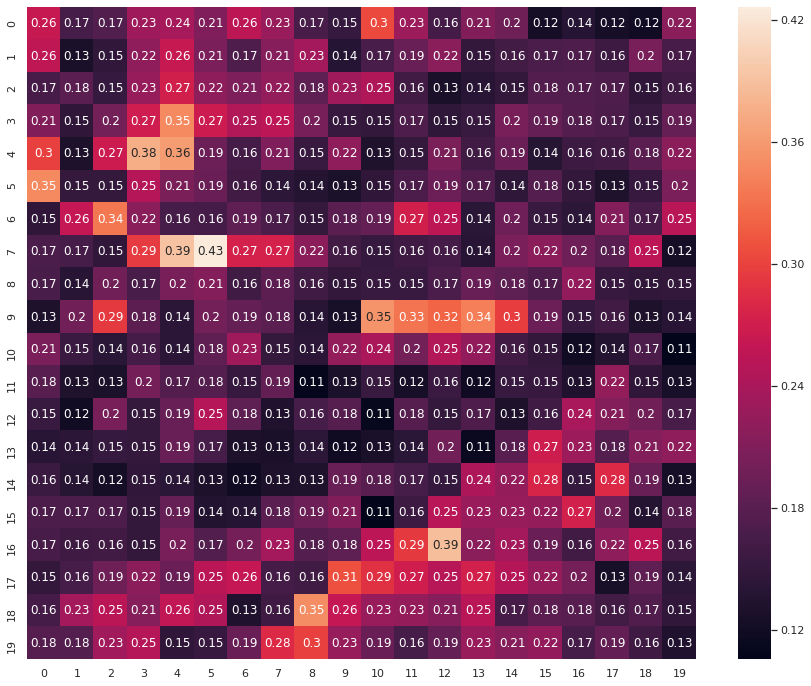

In [25]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
uniform_data = np.flipud(np.array(hm))
plt.subplots(figsize=(15,12))
ax = sns.heatmap(uniform_data, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(20.0, 0.0)

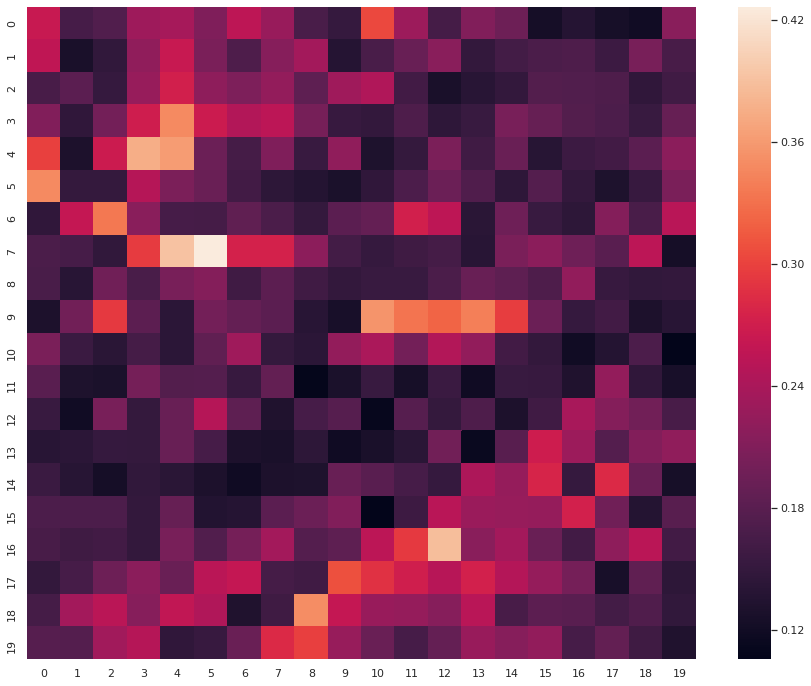

In [24]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
uniform_data = np.flipud(np.array(hm))
plt.subplots(figsize=(15,12))
ax = sns.heatmap(uniform_data, annot=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Heatmap of averaged data (small part)

(9.0, 0.0)

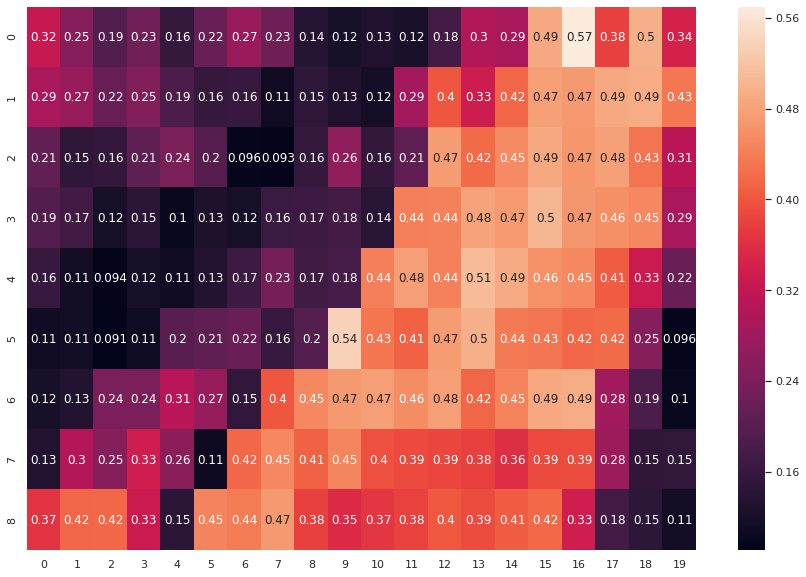

In [119]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
uniform_data = np.flipud(np.array(hm))
plt.subplots(figsize=(15,10))
ax = sns.heatmap(uniform_data, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [136]:
simulated_traces = pd.read_csv('../real_traces/SBOX_traces2019-11-04_16_35_27/traces/trace_sliced_4_13.csv',low_memory=False)
simulated_metadata= pd.read_csv('../real_traces/SBOX_traces2019-11-04_16_35_27/label/label_4_13.csv',low_memory=False)
simulated_traces = np.array(simulated_traces)
simulated_metadata = np.array(simulated_metadata)
        
corrAttackData = startCorrelationAttackSingle(simulated_traces[0:1000],simulated_metadata.T[0:1000])
allAttracks.append(corrAttackData)

--- Start Correlation Attack ---



--- Finished Correlation Attack --- 4199 1572932414.9654896
Key: 23 
Sample: 1531 
Correlation: 0.5084775257093045


In [34]:
def plotAllCorr(myData):
    maxCorr=[]
    myCounter = 0
    plt.figure(figsize=(30,10))
    for i in myData:
        maxCorr.append(i[1])
        if myCounter == 1531:
            final = maxCorr[myCounter]
        else:
            plt.plot(pd.DataFrame(maxCorr[myCounter]).abs(),color="blue")
        myCounter = myCounter + 1
    plt.plot(final,color="red")
    
    plt.show()
   
    #return test

In [ ]:
plotAllCorr(corrAttackData[0])

### Heatmap of none averaged Data - first trial

(10.0, 0.0)

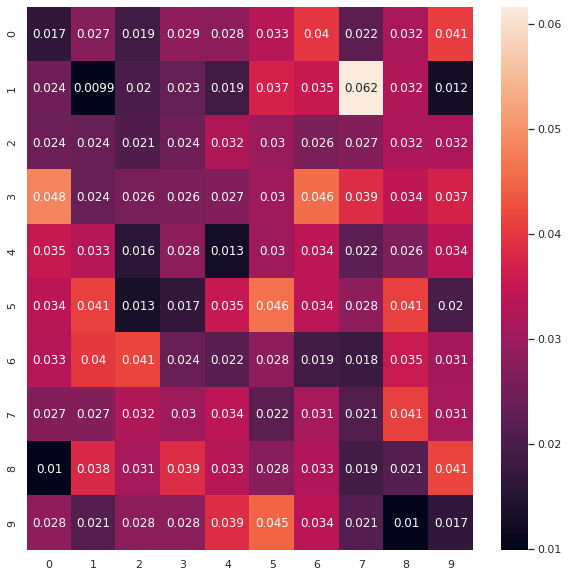

In [652]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
uniform_data = np.array(hm).T
plt.subplots(figsize=(10,10))
ax = sns.heatmap(uniform_data, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [615]:
def plotAllCorr(myData):
    maxCorr=[]
    for i in myData:
        maxCorr.append(i[1])
    plt.plot(maxCorr)
    plt.show()
    #return test

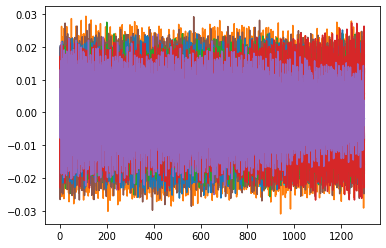

In [431]:
plotAllCorr(corrAttackData[0])

In [432]:
def plotSingleCorr(data):
    keyData = []
    corrData = []
    mergedData = []
    mergedData.clear()
    
    for i in data:
        
        keyData.append(i[0])
        corrData.append(i[1])
    mergedData = pd.DataFrame(corrData)
    mergedData['key'] = keyData 
    
    plt.plot(mergedData[0])
    plt.show()
    
    plt.plot(mergedData['key'])
    plt.show()
    
    plt.plot(mergedData)
    plt.show()

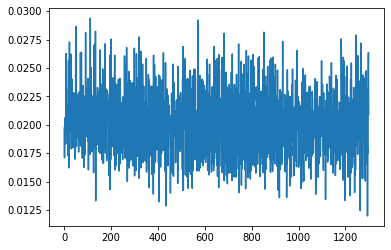

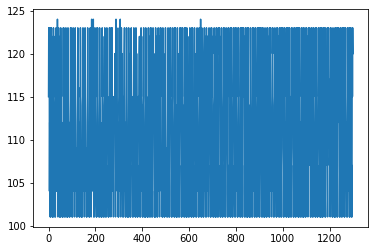

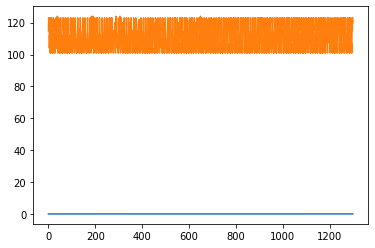

In [433]:
plotSingleCorr(corrAttackData[1])